# Dynamic time warping

Predicts the species of each flash sequence by finding the shortest distance, using dynamic time warping, to literature or population references.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, math
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, KFold
from dynamic_time_warping import *

Load binary sequence data, labels, and literature references.

In [3]:
# load data
df_path = '../data/real_data/flash_sequence_data.csv'
df = pd.read_csv(df_path, delimiter=',')
# keep only samples with number of flashes > 1
df = df.loc[df['num_flashes'] > 1].reset_index(drop=True) 
# unpack timeseries
df = pd.concat([df.iloc[:,:-1],pd.DataFrame(np.array(list(itertools.zip_longest(*[list(map(float,x.split(","))) for x in list(df.timeseries.values.flatten())],fillvalue=math.nan))).T
)],axis=1)

# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_6.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

## Classify by computing distance under DTW with literature references.

In [3]:
acc, prec, rec, prec_weighted, rec_weighted, conf_mat, y_true, y_pred, y_score, metrics = dtwLit(df, literature_sequences, literature_labels, 1)
print('Weighted precision =', prec_weighted)
print('Weighted Recall =', rec_weighted)

Weighted precision = 0.7283282871946084
Weighted Recall = 0.11882242077341895


In [4]:
# per-species precision and recall
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
for i in [df[df['species']==label].iloc[0].species_label for label in literature_labels]:
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], metrics[str(i)]['precision'], metrics[str(i)]['recall']))

P. bethaniensis precision = 0.02162, recall = 0.80034
P. carolinus precision = 0.96062, recall = 0.09252
P. forresti precision = 0.01627, recall = 0.13711
P. frontalis precision = 0.33784, recall = 0.09356
P. knulli precision = 0.10817, recall = 0.38944
P. obscurellus precision = 0.00390, recall = 0.01325


Plot ROC curve.

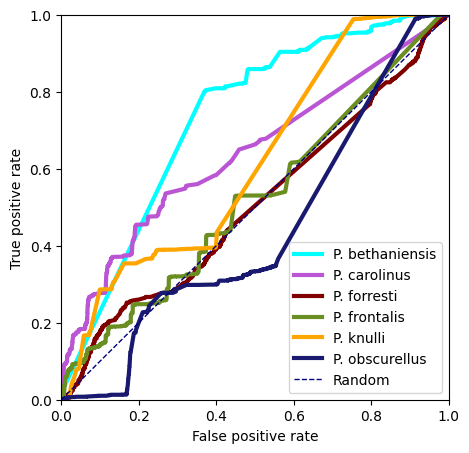

In [5]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}


for i, sp in enumerate([df[df['species']==label].iloc[0].species_label for label in literature_labels]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,i].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()


Plot confusion matrix.

[Text(0, 0.5, 'P. bethaniensis'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. forresti'),
 Text(0, 3.5, 'P. frontalis'),
 Text(0, 4.5, 'P. knulli'),
 Text(0, 5.5, 'P. obscurellus')]

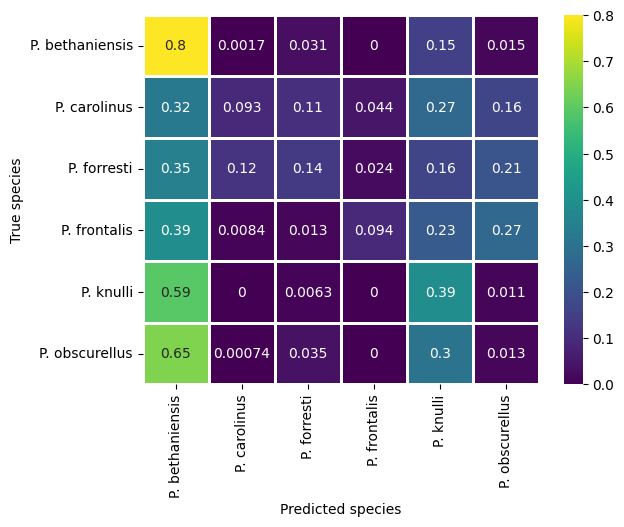

In [6]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(spec_labels[1:], rotation=90)
ax.set_yticklabels(spec_labels[1:], rotation=0)

In [7]:
# Optional: pickle the output
import pickle
data = {
    "acc": acc,
    "prec": prec,
    "rec": rec,
    "prec_weighted": prec_weighted,
    "rec_weighted": rec_weighted,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "metrics": metrics
}
with open("dtw_lit", "wb") as f:
        pickle.dump(data, f)

## Classify by computing distance under DTW with population references.

Import results from DTW with population references (using Matlab file dtw_popref.m) and compute classification metrics.

Generate list of indices for training and test using stratified k-fold cross validation.

In [4]:
num_species = len(np.unique(df['species_label']))
seed = 1
np.random.seed(seed)

df = df.sample(frac=1, random_state=seed) # shuffle df
reshuff_ind = df.index + 1
df = df.reset_index(drop=True)

k = 150 # number of folds
train_split = 0.8

# add +1 to indices to use with matlab
strat_cv = StratifiedKFold(n_splits=k)
train = []
test = []
for iter, (train_index, test_indices) in enumerate(strat_cv.split(df, df.species_label.values)):
    train_indices = []
    test_indices = (test_indices+1).tolist()
    for c in range(num_species):
        c_indices = train_index[np.where(df.iloc[train_index].species_label == c)] # get which train indices belong to species c
        mi = np.min(df.iloc[train_index].species_label.value_counts())
        k_inner = int(len(c_indices)/(mi*train_split))
        if k_inner > 1:
            inner_split = KFold(n_splits=k_inner)
            for j, (tr_i, te_i) in enumerate(inner_split.split(c_indices)):
                if iter % k_inner == j:
                    train_indices.extend(c_indices[te_i]+1)
                    test_indices.extend(c_indices[tr_i]+1)
        else:
            k_inner = int(len(c_indices)/(len(c_indices) - mi*train_split))
            inner_split = KFold(n_splits=k_inner)
            for j, (tr_i, te_i) in enumerate(inner_split.split(c_indices)):
                if iter % k_inner == j:
                    train_indices.extend(c_indices[tr_i]+1)
                    test_indices.extend(c_indices[te_i]+1)
    train.append(train_indices)
    test.append(test_indices)

In [9]:
import csv

with open('train_indices.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(train)

with open('test_indices.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test)
    
with open('reshuff_indices.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(reshuff_ind.tolist())

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.dtw_popref(nargout=0)
eng.quit()

Analyze classification results.

In [5]:
y_true = pd.read_csv('dtw_y_true.csv',header=None)
y_pred = pd.read_csv('dtw_y_pred.csv',header=None)
y_score = pd.read_csv('dtw_y_score.csv',header=None)

accs = []
precs = []
recs = []
precs_weighted = []
recs_weighted = []
precs_sp = np.zeros((num_species, k))
recs_sp = np.zeros((num_species,k))
count = 0
for i in range(k):
    yt = y_true[count:count+len(test[i])]
    yp = y_pred[count:count+len(test[i])]
    count = count + len(test[i])
    metrics = classification_report(yt,yp,output_dict=True)
    acc = metrics['accuracy']
    prec = metrics['macro avg']['precision']
    rec = metrics['macro avg']['recall']
    prec_weighted = metrics['weighted avg']['precision']
    rec_weighted = metrics['weighted avg']['recall']
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    precs_weighted.append(prec_weighted)
    recs_weighted.append(rec_weighted)
    for sp in range(num_species):
        precs_sp[sp,i] = metrics[str(sp)]['precision']
        recs_sp[sp,i] = metrics[str(sp)]['recall']

In [6]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall weighted precision = {0:2.5f}'.format(np.mean(precs_weighted)), ' +/- {0:2.5f}'.format(np.std(precs_weighted)))
print('Overall weighted recall = {0:2.5f}'.format(np.mean(recs_weighted)), ' +/- {0:2.5f}'.format(np.std(recs_weighted)))
for i in range(len(spec_labels)):
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], np.mean(precs_sp[i]), np.mean(recs_sp[i])))

Overall weighted precision = 0.77255  +/- 0.00398
Overall weighted recall = 0.47495  +/- 0.00524
B. wickershamorum precision = 0.71285, recall = 0.62190
P. bethaniensis precision = 0.04243, recall = 0.65668
P. carolinus precision = 0.93637, recall = 0.31624
P. forresti precision = 0.00481, recall = 0.31979
P. frontalis precision = 0.49032, recall = 0.92845
P. knulli precision = 0.24377, recall = 0.64701
P. obscurellus precision = 0.26490, recall = 0.59241


Plot confusion matrix.

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7')]

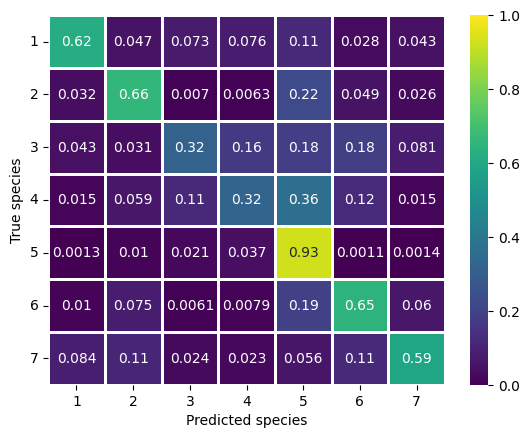

In [7]:
conf_mat = confusion_matrix(y_true,y_pred,normalize='true')
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g',vmin=0,vmax=1)
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
spec_labels=['1','2','3','4','5','6','7']

ax.set_xticklabels(spec_labels, rotation=0)
ax.set_yticklabels(spec_labels, rotation=0)

Plot ROC curves.

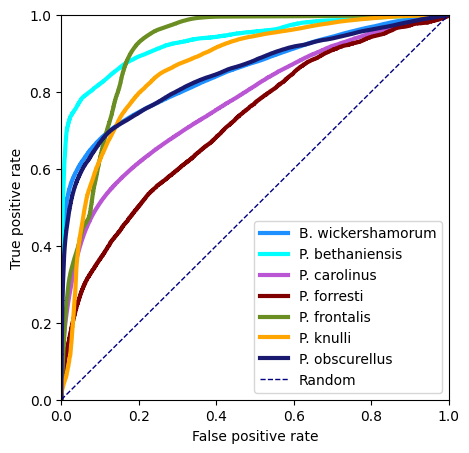

In [14]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}
fprs = [] # to delete
tprs = [] # to delete
for sp in range(len(np.unique(df['species_label']))):
    fpr, tpr, thresholds = roc_curve(y_true, y_score.to_numpy()[:,sp].flatten(), pos_label=sp)
    lw = 3
    fprs.append(fpr) # to delete
    tprs.append(tpr) # to delete
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()
# to delete
from scipy.io import savemat
mdic = {"fprs": fprs, "tprs": tprs}
savemat("dtw_pop_revision.mat", mdic)